# Program for generating figure 6b

## Prepare packages and basic data

In [25]:
#!pip install statsmodels

In [26]:
import glob
import os
# Ignore warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

#Process data
import pandas as pd
import numpy as np
import xarray as xr


In [27]:
#Display data 
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt

In [28]:
import statsmodels.api as sm

In [29]:
# calculated area of each grid in unit square meter
areainsqmeter=np.load('originalcode/code/ipynb/areainsqmeter_squared_meter_great_lake_region_35N65N.npy')

#maize land use
## combined (irr + rainfed)
combined_landuse=np.load('originalcode/code/ipynb/combined_landuse_35N65N.npy')
## rainfed maize land use
rainfed_landuse=np.load('originalcode/code/ipynb/rainfed_landuse_35N65N.npy')
## irrigated maize land use
irrigated_landuse=np.load('originalcode/code/ipynb/irrigated_landuse_35N65N.npy')
# SPAM maize combined production 
spam_production=np.load('average_all.npy')
spam_production=np.where(spam_production <= 0, np.nan, spam_production) #remove grids with value <=0

In [30]:
np.nanpercentile(spam_production,1)

6.004332993825277

In [31]:
#data from https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3_grid_by_GCM_and_GGCM_1983_2099/
file='/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_Maize_ssp126_gfdl-esm4_2015co2_ensemble_mean.nc4'
ds=xr.open_dataset(file,decode_times=False)

In [32]:
ds

<xarray.Dataset>
Dimensions:       (lon: 720, lat: 360, years: 117)
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years         (years) int32 1983 1984 1985 1986 1987 ... 2096 2097 2098 2099
Data variables:
    yield change  (years, lat, lon) float64 ...

## 1. test dataset

In [33]:
# define initial study region
min_lon = -100 
min_lat = 35
max_lon = -70
max_lat = 65

In [34]:
# set path of data 
Path='/media/Data1/Climada/isimip3/nc4/'
# climate models
gcms=['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']
# crop models
ggcms=['acea','crover','cygma1p74','dssat-pythia','epic-iiasa',
       'ldndc','lpjml','pdssat','pepic','promet','simplace-lintul5','isam']


### Note: Jonas Jägermeyr's data reference period is 1983-2013 (31 years)

## Check the ratio of simulated production against observation from SPAM 

In [35]:
file='/media/Data1/Climada/ISIMIP3b/Data/acea_mri-esm2-0_w5e5_historical_2015soc_default_yield-mai-firr_global_annual-gs_1850_2014.nc'
ds=xr.open_dataset(file,decode_times=False)
ds

<xarray.Dataset>
Dimensions:         (lon: 720, lat: 360, time: 165)
Coordinates:
  * lon             (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat             (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time            (time) float64 249.0 250.0 251.0 252.0 ... 411.0 412.0 413.0
Data variables:
    yield-mai-firr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_id:                7e9853ed-f08b-46d7-8245-59a50e101a7d
    isimip_protocol_version:  b57c1cb304874b20c114a66b7f8c39d9259863ab
    isimip_qc_pass_date:      2021-09-24 09:03 UTC
    isimip_qc_version:        2.7.0

In [36]:
#check if all data are available
# define an array to store percentiles 25th, 50th and 75th 5th and 95th percentiles
prod60X60=np.full((60, 60, 12,5), np.nan)  #X, Y, ggcm,gcm 
ratio60X60=np.full((60, 60, 60), np.nan)  #X, Y, Simulations 
ptl=np.full((60, 5), np.nan) 
ptl50=np.full((12,5),np.nan) #save median as 12X5 array 
ij=0
ii=0

for ggcm in ggcms:  #crop models
    jj=0
    for gcm in gcms:   #climate models
        s1="/media/Data1/Climada/ISIMIP3b/Data/"
        s2=ggcm+'_'+gcm
        s3='_w5e5_historical_2015soc_default_yield-mai-*.nc'  #maize yield data files
        s4=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-firr*.nc'    #irrigated
        s5=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-noirr*.nc'   #rainfed
        ss=s1+s2+s3  #maize yield files, to check if there are 2 files
        fns=glob.glob(ss)
        if len(fns)<2:  
            print(ggcm+' '+gcm+' '+str(len(fns)))
            continue
        else:
            #irrigated
            fns1=glob.glob(s4)
            if ij==0 and ii==0:
                print(fns1[0])
            file1=fns1[0]   #irrigated file
            ds=xr.open_dataset(file1,decode_times=False)
            # substract data for the last 19 years, 1995 to 2014
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(394,413))
                #average over years rainfed
            crop_isimip3b1_mean=cropped_ds.mean(dim='time')*irrigated_landuse/100
            
            #rainfed maize file
            fns2=glob.glob(s5)
            #print(fns2[0])
            file1=fns2[0]
            ds=xr.open_dataset(file1,decode_times=False)
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(394,413))
                #average over years and sum over rainfed
            crop_isimip3b2_mean=cropped_ds.mean(dim='time')*rainfed_landuse/100  #average over time and landuse (%)         
            # combined yield for each grid
            crop_isimip3b_mean= crop_isimip3b1_mean['yield-mai-firr'].fillna(0) \
                                +crop_isimip3b2_mean['yield-mai-noirr'].fillna(0)
            #production on each grid: 1ha = 10000 m^2
            prod=crop_isimip3b_mean*areainsqmeter/10000
            
            #check the ratio rather than absolute production
            ratio=prod/spam_production
            prod60X60[:,:,ii,jj]=prod
            ratio60X60[:,:,ij]=ratio
            d1=np.array(ratio).ravel()


            d2=d1[~np.isnan(d1)]  #remove grid without maize
            d2=d2[d2>0]   #remove grid with production<=0
            percentile_75 = np.percentile(d2, 75)   #75th percentiles
            percentile_25 = np.percentile(d2, 25)   #25th percentiles
            percentile_50 = np.percentile(d2, 50)   #50th percentiles or mediean values         
            d95=np.nanpercentile(d2, 95)  #95th percentile
            d05=np.nanpercentile(d2, 5)   #5th percentile
            d3=d2[d2<d95]   #remove extreme high values
            d3=d3[d3>d05]   #remove extreme low values

            ptl[ij,:]=[percentile_25,percentile_50,percentile_75, d05,d95]  #save 25th, 50th and 75th percentiles
            print(len(d2),[d05,percentile_25,percentile_50,percentile_75,d95],len(d3)) #display results
            ptl50[ii,jj]=percentile_50
            ij=ij+1
        jj=jj+1
    ii=ii+1
np.save('isimip3b_production_60X60X12ggcmsX5gcms.npy',prod60X60)            

acea gfdl-esm4 0
acea ipsl-cm6a-lr 0
acea mpi-esm1-2-hr 0
/media/Data1/Climada/ISIMIP3b/Data/acea_mri-esm2-0_w5e5_historical_2015soc_default_yield-mai-firr_global_annual-gs_1850_2014.nc
1261 [0.6270288123533158, 1.0902970628259614, 1.7833565397477114, 4.373717572038798, 31.193971214200882] 1133
1261 [0.6006856109037638, 1.043819008395248, 1.7491676017396698, 4.251488325857521, 28.849816173701203] 1133
1219 [0.3273779481416216, 0.5259630576293859, 0.8607045423327113, 1.948837930755471, 14.004875950766802] 1097
1219 [0.3306772454234783, 0.5288708272599347, 0.8744615178409542, 1.9754186951446115, 13.974402738272435] 1097
1219 [0.31823167831246235, 0.5355397834427407, 0.8764236542372895, 1.9973364668315159, 13.97304200707483] 1097
1219 [0.3279252544827907, 0.5357329313093252, 0.8849603942597509, 2.0093011849371845, 14.264945109248089] 1097
1219 [0.31543225625203875, 0.5187606142823968, 0.8535037376285612, 1.9362676570150974, 13.532227023165337] 1097
1261 [0.46209233094045343, 0.77512491928

In [37]:
ratio.shape

(60, 60)

In [38]:
np.nanmean(prod60X60,3).shape

(60, 60, 12)

[695763.0017034883, 67.72217370670297]
[736453.1298145503, 349.29091478591795]
[208110.27919999015, 260886.94599513628]


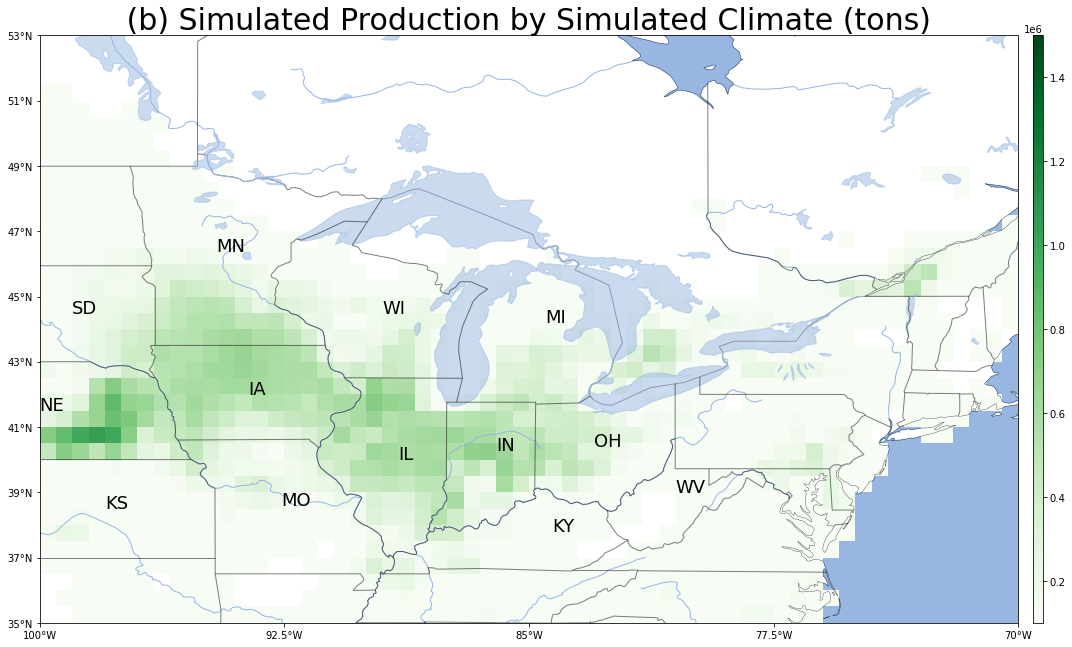

In [39]:
#Display data 
fn='/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4'
ds=xr.open_dataset(fn,decode_times=False)
cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=1.0).fillna(0)
cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=2.0).fillna(0)

#average over years and sum over irrigated and rainfed
crop_isimip3a1_mean=cropped_ds1.mean(dim='years')*rainfed_landuse/100
crop_isimip3a2_mean=cropped_ds2.mean(dim='years')*irrigated_landuse/100
crop_isimip3a_mean= crop_isimip3a1_mean+crop_isimip3a2_mean
#mask=np.load('/media/Data1/Climada/isimip3/reference/maize_combined_observational_mask.npy')
mask=np.load('/media/Data1/Climada/isimip3/reference/isimip3b_mask60X60.npy')
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt

provinces= ['Ontario', 'Quebec','Manitoba','Wisconsin','Vermont','Nebraska','New York','Kansas','Illinois',
            'Delaware','Connecticut','Indiana','Missouri','Michigan','New Jersey','Kentucky','Minnesota',
            'Ohio','Iowa','Pennsylvania','Maryland','Virginia','West Virginia','North Dakota','South Dakota','Nunavut']
provinces1=['ON','QC','MB','WI','VT','NE','NY','KS','IL','DE','CT','IN','MO','MI','NJ','KY','MN','OH','IA','PA','MD','VA','WV','ND','SD','NU']
Latitudes= [50,53,56.4,44.5,44,41.5,43,38.5,40,39,41.6,40.3,38.6,44.2,39.8,37.8,46.4,
            40.4,42,41.2,39,38,39,47.7,44.5,62]
Longitudes=[-85,-76,-98.7,-89.5,-72,-100,-75,-98,-89,-73.5,-72.7,-86,-92.6,-84.5,-74.9,-84.3,-94.6,
            -83,-93.6,-77.2,-76.6,-78,-80.5,-99,-99,-98]

lats = crop_isimip3a_mean.coords['lat'][:]
lons = crop_isimip3a_mean.coords['lon'][:]
X,Y = np.meshgrid(lons,lats)
projection = ccrs.PlateCarree()
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')
axes_class = (GeoAxes,
              dict(map_projection=projection))
# lons, lats = np.meshgrid(lons, lats)
title_text=["Refereance", "2050s", "2080s"]
fig = plt.figure(figsize=(15,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1%',
                label_mode='')  # note the empty labe
for i, ax in enumerate(axgr):
#*************************************************************
    if i==0:
        data=np.nanmean(np.nanmean(prod60X60,axis=3),axis=2)
        data=np.where(data == 0, np.nan, data)
        data=data*mask
#         mask=np.where(data >=0,1,data)
        subtitle=" (b) Simulated Production by Simulated Climate (tons) "
        print([np.nanpercentile(data,99.0),np.nanpercentile(data,0)])
        print([np.nanpercentile(data[37:56,:40],99.0),np.nanpercentile(data[37:56,:40],0)])
        print([np.nanpercentile(data[37:56,:40],50.0),np.nanmean(data[37:56,:40])])          
  
                     
#add ocean, coastline,borders,lakes,rivers,provinc_bodr
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(provinc_bodr, linestyle='-', linewidth=1, edgecolor="k", zorder=10, alpha=0.5)
    ax.set_title(subtitle, fontsize=30)
    ax.set_xlim([-100,-70])
    ax.set_ylim([35,53])
    ax.set_xticks(np.linspace(-100, -70, 5), crs=projection)
    ax.set_yticks(np.linspace(35, 53, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
#     p = ax.contourf(lons, lats, data,50,
#                         transform=projection,
#                         cmap='BrBG')
    
#     l = ax.contour(lons, lats, data,25,colors=['black'], linewidth=0.3,
#                         transform=ccrs.PlateCarree())
    for iprov in range(26):
        if Longitudes[iprov]<-80 and Latitudes[iprov]<47:
            ax.text(Longitudes[iprov],Latitudes[iprov],provinces1[iprov],fontsize=18)
#     p = ax.pcolormesh(X, Y, data,
#                       vmin=-300,
#                       vmax=300,
#                       transform=projection,
#                       cmap='Reds')
    p = ax.pcolormesh(X, Y, data,
                      transform=projection,
                      vmin=100000,
                      vmax=1500000,
                      cmap='Greens')    
#     ax.clabel(
#         l,  # Typically best results when labelling line contours.
#         colors=['black'],
#         manual=False,  # Automatic placement vs manual placement.
#         inline=True,  # Cut the line where the label will be placed.
#         fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
#     )
axgr.cbar_axes[0].colorbar(p)
plt.tight_layout()
plt.show()
fig.savefig('Figure_6b_isimip3b_production_for_maize_20Years.png',dpi=150)